# Creating qutrit circuits for simulation

This tutorial shows how to embed qubit gates in a circuit with qutrit instructions. These instructions are then simulated with a SuperOperator to allow for non-unitary channels. This allows us to study the dynamics of leakage and damping for transmons under the assumptions that the gates may have leakage.

## Embedding standard unitary qubit gates

First we show how to embed standard qubit gates in `QutritUnitaryGate` instructions. These instructions store the time-evolved unitary operation in the instruction parameters and have a `to_matrix` method that returns the unitary acting on the qutrit space.

In [1]:
import numpy as np

from qiskit import QuantumCircuit
from qiskit.circuit.library import RXGate, RYGate, CPhaseGate

from restless_simulator.circuit import QutritUnitaryGate
from restless_simulator.quantum_info.converters import circuit_to_qudit_circuit

First, we create a standard quantum circuit.

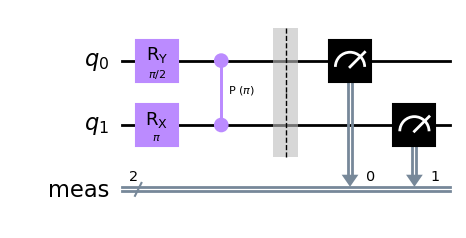

In [2]:
circuit = QuantumCircuit(2)
circuit.ry(0.5 * np.pi, 0)
circuit.rx(np.pi, 1)
circuit.cp(np.pi, 0, 1)
circuit.measure_all()
circuit.draw("mpl")

Next, we convert this quantum circuit with `circuit_to_qudit_circuit`. Here, we also remove the final measurement as we are only interested in the channel of the unitary part of the circuit.

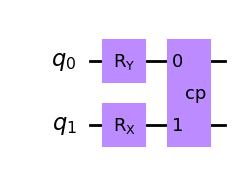

In [3]:
converted_circuit = circuit_to_qudit_circuit(circuit.remove_final_measurements(inplace=False))
converted_circuit.draw("mpl")

Alternatively, we could have built the circuit manually by adding qutrit gates to it.

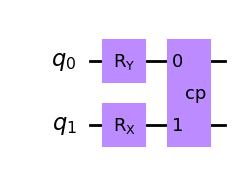

In [4]:
qt_ry = QutritUnitaryGate.from_qubit_gate(RYGate(0.5 * np.pi, label="ry"))
qt_rx = QutritUnitaryGate.from_qubit_gate(RXGate(np.pi, label="rx"))
qt_rzz = QutritUnitaryGate.from_qubit_gate(CPhaseGate(np.pi, label="cp"))

circuit2 = QuantumCircuit(2)
circuit2.append(qt_ry, (0,))
circuit2.append(qt_rx, (1,))
circuit2.append(qt_rzz, (0, 1))
circuit2.draw("mpl")

In [5]:
converted_circuit == circuit2

True

We now convert the circuit to a super operator so that we can compute the time-evolution of density matrices.

In [6]:
from qiskit.quantum_info import DensityMatrix, Kraus, SuperOp

from restless_simulator.circuit import QutritUnitaryGate
from restless_simulator.quantum_info import qudit_circuit_to_super_op

# Convert the circuit to a super operator
sop = qudit_circuit_to_super_op(converted_circuit)

We now create the density matrix $\vert0\rangle\langle0\vert$ of the ground state and evolve it with the circuit shown above. We will display the results in the subspace spanned by $\{\vert10\rangle, \vert11\rangle\}$. Here, the ordering is $\vert q_1, q_0\rangle$.

In [7]:
# Initial state
data = np.zeros((9, 9))
data[0, 0] = 1
rho = DensityMatrix(data)

# evolved state
rho_sub = rho.evolve(sop).data[3:5, 3:5]

The figures below nicely illustrate the density matrix of the coherent state $(\vert10\rangle-\vert11\rangle)/\scriptsize{\sqrt{2}}$.

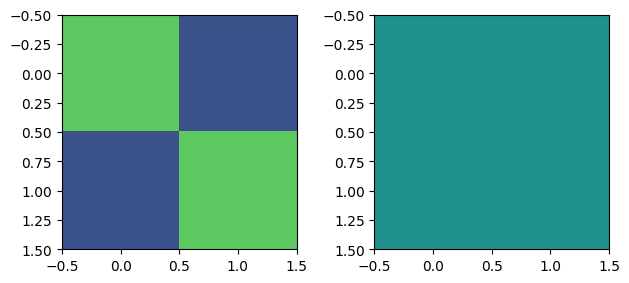

In [8]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2)
axs[0].imshow(np.real(rho_sub), vmin=-1, vmax=1)
axs[1].imshow(np.imag(rho_sub), vmin=-1, vmax=1)
plt.tight_layout()

## Non-unitary instructions

To illustrate how non-unitary operations can be added to the circuit we now add an amplitude damping channel to our quantum circuit. This amplitude damping channel is chosen to have an unusually strong decay to make the effects of the damping visually appearent.

In [9]:
from restless_simulator.quantum_info import amplitude_damping_channel
from restless_simulator.circuit import QutritQuantumChannelOperation

In [10]:
kraus_damp = amplitude_damping_channel(0.2, 0.282)
damp_chan = QutritQuantumChannelOperation(kraus_damp, name="Amp. Damp.")

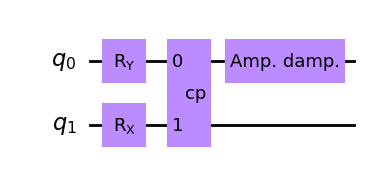

In [14]:
converted_circuit.append(damp_chan, (0, ))
converted_circuit.draw("mpl")

In [15]:
sop_damp = qudit_circuit_to_super_op(converted_circuit)

As before, we evolve the $\vert0\rangle\langle0\vert$ state and focus on the density matrix in the $\{\vert10\rangle, \vert11\rangle\}$ sub-space.

In [16]:
rho_sub_damp = rho.evolve(sop_damp).data[3:5, 3:5]

We observe that the amplitude damping channel has increased the population in the $\vert10\rangle$ state, decreased to coherences, and increased the population in the $\vert10\rangle$. This is expected since we only added a damping channel to qubit 0.

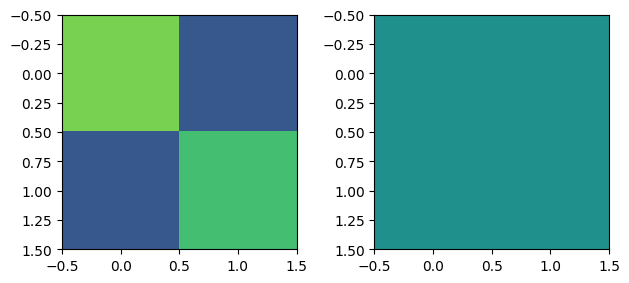

In [17]:
fig, axs = plt.subplots(1, 2)
axs[0].imshow(np.real(rho_sub_damp), vmin=-1, vmax=1)
axs[1].imshow(np.imag(rho_sub_damp), vmin=-1, vmax=1)
plt.tight_layout()